# Chap07 - 베이지안 A/B 테스트

## 7.1 서론

> 가용성	테스트(split	test,	A/B	테스트,	사용성	테스트)은	전체	디자인	중	한	가지	요소를	두	가지	이상의	버전으로	실험하여	무엇이	더	나은지를	판별하는	기법입니다.	보통은	기존	버전(A)과	새로운	버전(B)를	준비하여 랜덤하게	방문하는	사용자별로	다른	버전을	보여준	후,	의도하는	결과가	높게	나오는	쪽이	어느	쪽인지를	검증한다.

## 7.2 전환율 테스트 개요

A/B 테스트의 기본적인 아이디어는 다음과 같다. 인과관계가 완벽한 세상이라고 가정할 경우, 연구 중인 두 집단은 동일하지만 어떠한 테스트에 따라 집단 간의 차이가 원인이 되어 나타난다. 하지만 실제 세계에서는 이러한 완벽한 세상에 접근할 수 없으므로 대량의 데이터를 이용하여 테스트한다.

[2장](https://render.githubusercontent.com/view/ipynb?commit=43cfc07989b3f220fe736b1887ee5fb05a1c052b&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f457863656c73696f72434a482f426179657369616e2d776974682d507974686f6e2f343363666330373938396233663232306665373336623138383765653566623035613163303532622f4368617030322d4d6f726550794d432f4368617030322d4d6f726550794d432e6970796e62&nwo=ExcelsiorCJH%2FBayesian-with-Python&path=Chap02-MorePyMC%2FChap02-MorePyMC.ipynb&repository_id=125394920&repository_type=Repository#2.2.2-%EC%98%88%EC%A0%9C:-%EB%B2%A0%EC%9D%B4%EC%A7%80%EC%95%88-A/B-%ED%85%8C%EC%8A%A4%ED%8A%B8)에서 다뤘던 예제를 다시 보도록 하자. 다음과 같이 A, B 사이트에대한 방문자 수와 전환된 방문자 수라고 하자.

```python
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125
```

여기서 우리가 궁금한 것은 A 또는 B 사이트가 주어졌을 때의 전환확률이다. 우리의 목표는 A, B 중에서 어느 사이트의 전환확률이 높은지 알아보는 것이다. 이를 위해 A사이트 또는 B사이트가 주어진 경우 전환확률을 모델링 한다. 확률을 모델링하는 것이므로 사전확률분포로는 베타분포가 좋다(확률처럼 0과 1사이의 값으로 제한되기 때문). 방문자와 전환데이터 숫자는 이항적(discrete)이다. A 사이트의 경우 1,300번 중 120번이 성공했다. 

[6장](https://render.githubusercontent.com/view/ipynb?commit=43cfc07989b3f220fe736b1887ee5fb05a1c052b&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f457863656c73696f72434a482f426179657369616e2d776974682d507974686f6e2f343363666330373938396233663232306665373336623138383765653566623035613163303532622f4368617030362d5072696f7269746965732f4368617030362d5072696f72732e6970796e62&nwo=ExcelsiorCJH%2FBayesian-with-Python&path=Chap06-Priorities%2FChap06-Priors.ipynb&repository_id=125394920&repository_type=Repository#6.6-%EC%BC%A4%EB%A0%88-%EC%82%AC%EC%A0%84%ED%99%95%EB%A5%A0%EB%B6%84%ED%8F%AC)에서 알아 보았듯이 베타사전확률분포와 이항관측치(데이터)가 켤레 관계임을 알 수 있다. 즉, MCMC를 수행할 필요가 없다. 

만약 사전확률분포가 $\text{Beta} (\alpha_0, \beta_0)$ 이고 실험 $N$번, 성공 $X$개면 사후확률분포는 $\te4xt{Beta} (\alpha_0 + X, \beta_0 + N - X)이며 `SciPy`의 `beta`함수를 사용하여 사후확률분포에서 바로 표본을 추출할 수  있다.

In [1]:
visitors_to_A = 1300
visitors_to_B = 1275
conversions_from_A = 120
conversions_from_B = 125

In [2]:
from scipy.stats import beta

alpha_prior = 1
beta_prior = 1
posterior_A = beta(alpha_prior + conversions_from_A,
    beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
    beta_prior + visitors_to_B - conversions_from_B)

In [3]:
samples = 20000 # 더 나은 근사를 위해서는 이 값이 더 커야 한다 # We want this to be large to get a better approximation.
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)
print ((samples_posterior_A > samples_posterior_B).mean())

0.309


In [9]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

matplotlib.rc('font', family='NanumGothic')  # Linux
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

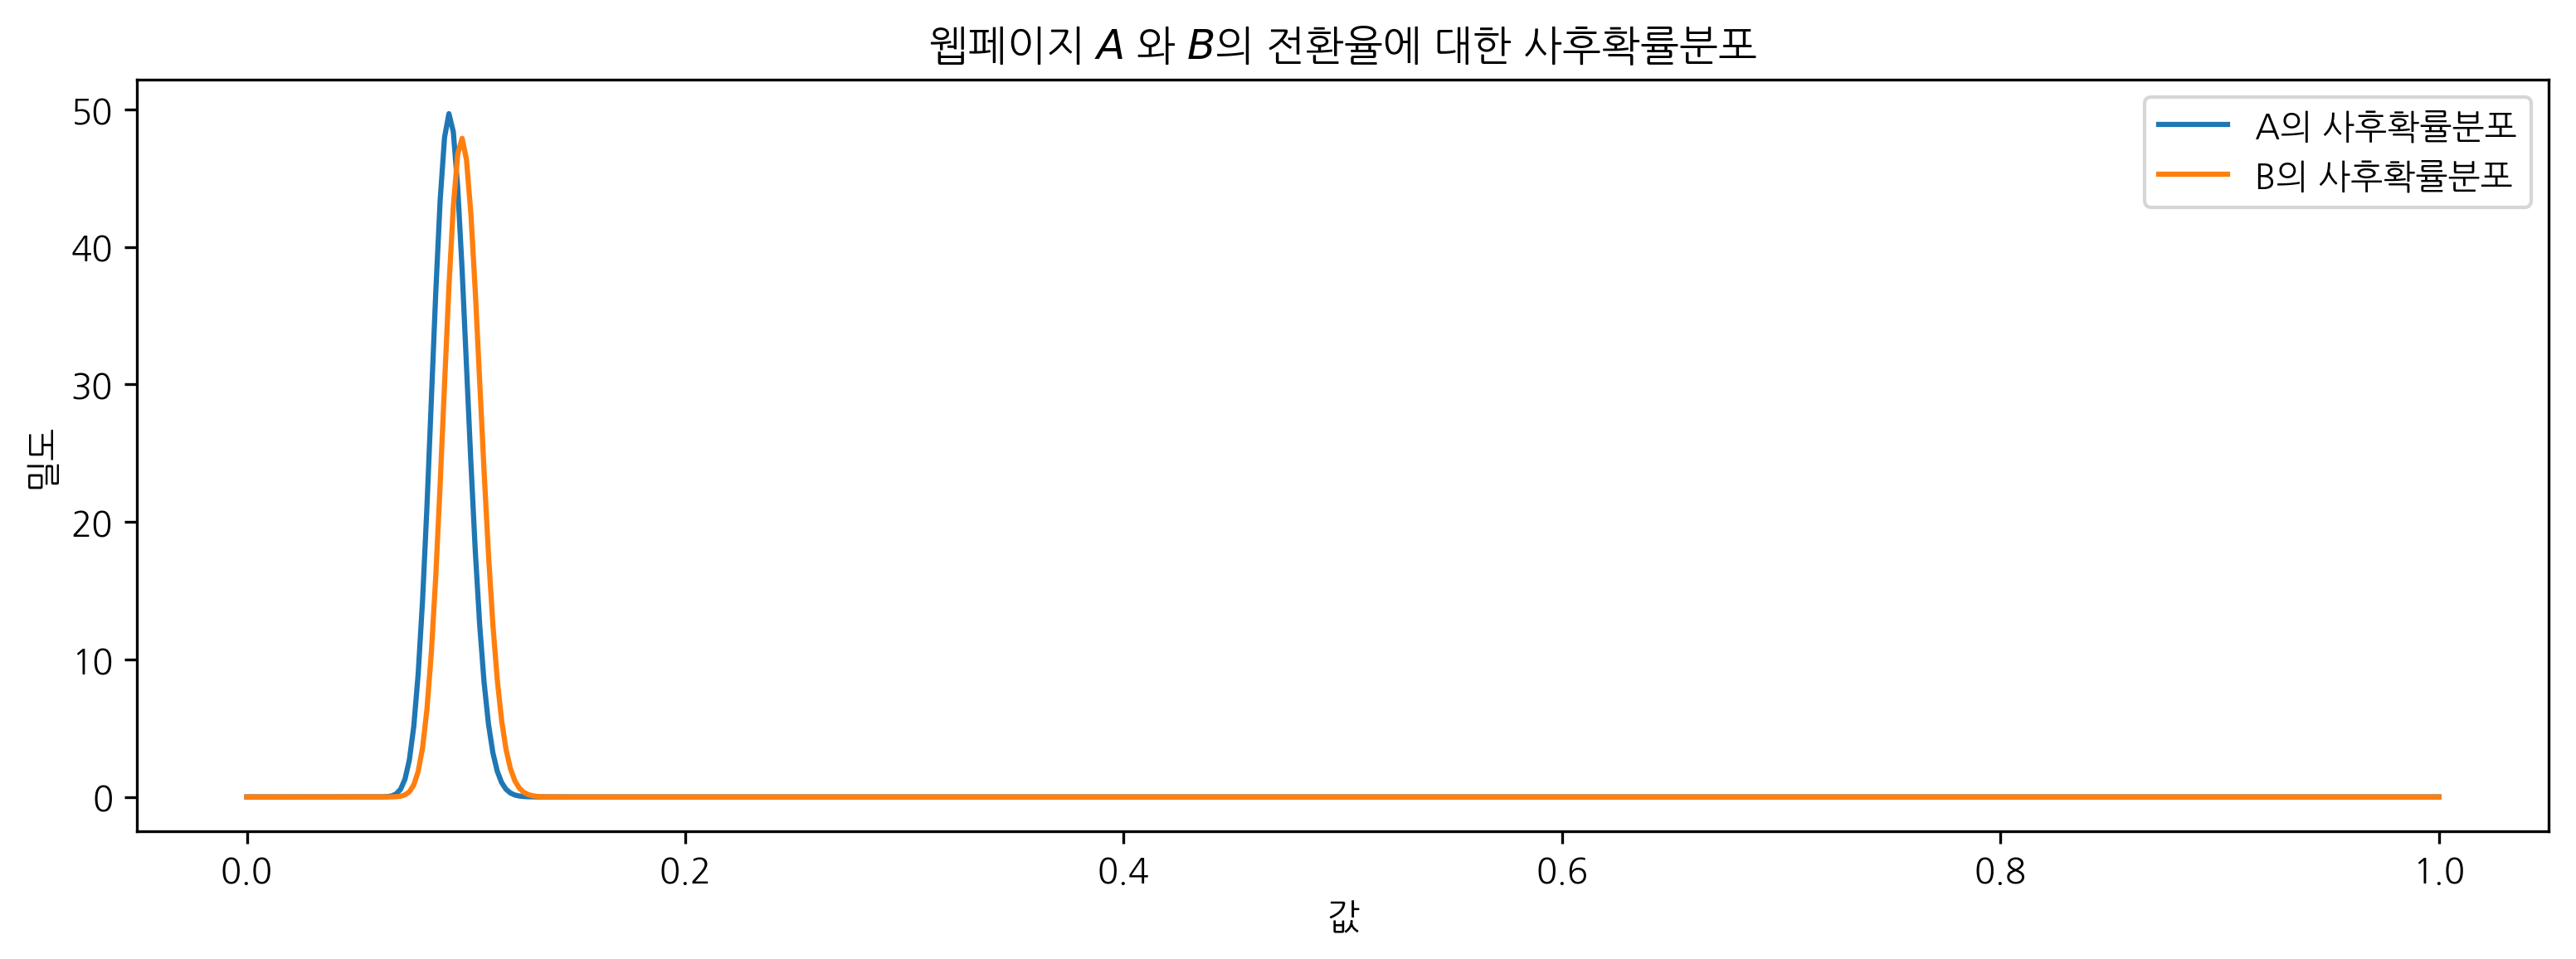

In [10]:
x = np.linspace(0,1, 500)
plt.plot(x, posterior_A.pdf(x), label='A의 사후확률분포')
plt.plot(x, posterior_B.pdf(x), label='B의 사후확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 $A$ 와 $B$의 전환율에 대한 사후확률분포")
plt.legend();

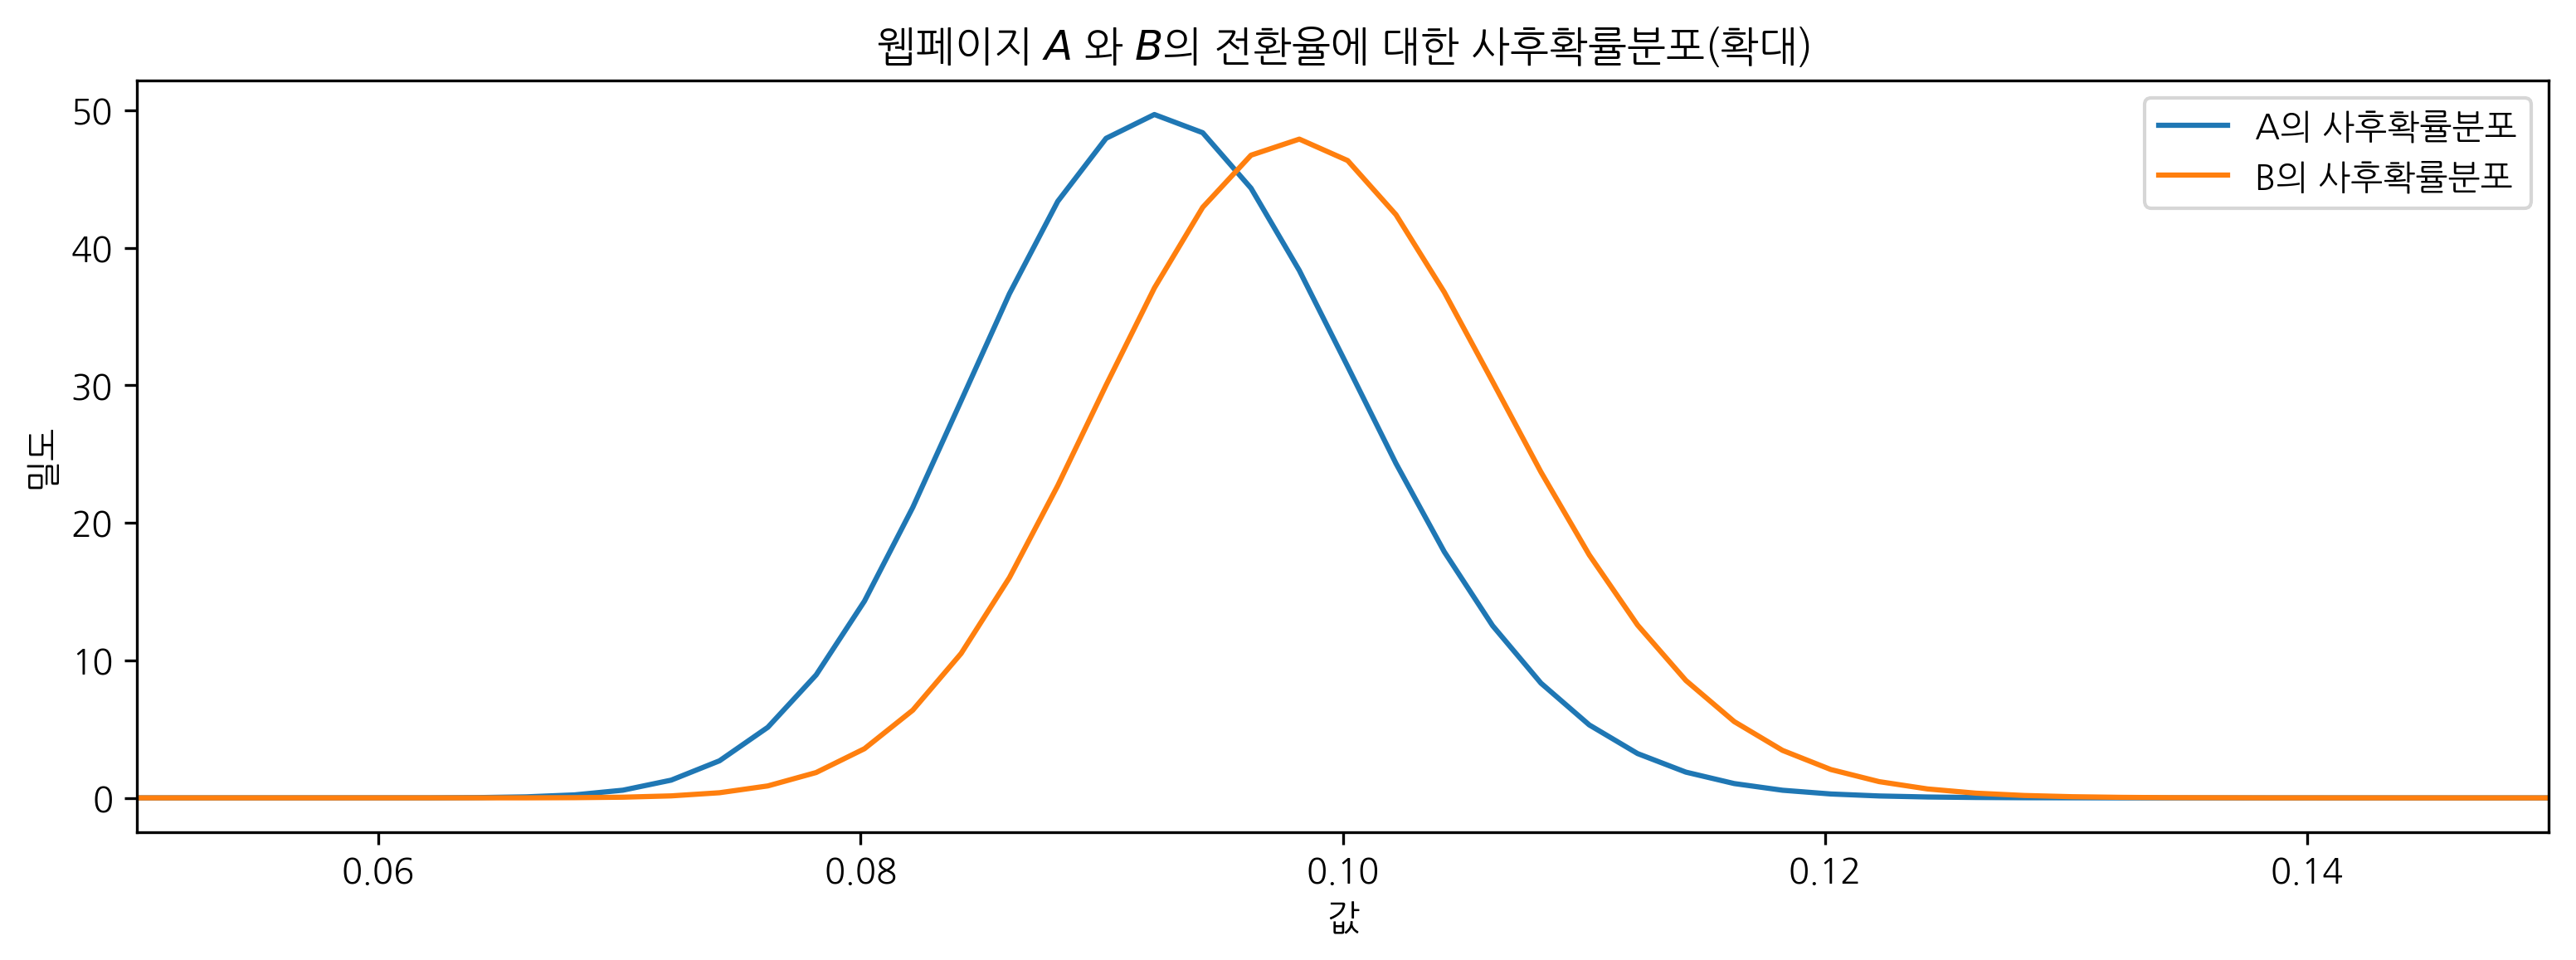

In [11]:
plt.plot(x, posterior_A.pdf(x), label='A의 사후확률분포')
plt.plot(x, posterior_B.pdf(x), label='B의 사후확률분포')
plt.xlim(0.05, 0.15)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 $A$ 와 $B$의 전환율에 대한 사후확률분포(확대)")
plt.legend();

## 7.3 선형손실함수 추가하기

> 인터넷 기업의 공통된 목표는 가입자를 모으는 것뿐만 아니라 사용자가 선택할 수 있는 가입약정요금제를 최적화하는 것이다. 예를 들어 기업은 둘 이상의 선택지를 제시했을 때 고객이 높은 가격의 약정요금제를 선택하기를 원할 것이다.
사용자는 두 가지 다른 약정 페이지에 노출되어 있고, 우리는 이로부터 얻는 기대수익을 알고 싶다. 이전의 A/B 테스트 분석은 사용자의 가입 여부에만 관심을 두었다. 이제 우리는 얼마의 기대수익을 얻을 수 있는지도 알고 싶다.

### 7.3.1 기대수익분석

잠시 A/B 테스트를 잊고 하나의 웹페이지 스타일에 대한 분석을 고려해보자. 우리가 모든 걸 알고 있는 완벽히 투명한 세상이라면 이 가상으로 만든 회사의 기댓값을 계산할 수 있다.

$$
E[R] = 79p_{79} + 49p_{49} + 25p_{25} + 0p_0
$$

여기서 p79는 \$79 약정을 선택할 확률이다. 약정을 선택하지 않는 사람들을 고려하여 가상의 $0 약정을 포함시켰다. 이것까지 포함하여 확률의 합은 1이다.

$$
p_{79} + p_{49} + p_{25} + p_0 = 1
$$

다음 단계는 이 확률을 추정하는 것이다. 각각의 확률이 상관되어 있으므로(총합이 1) 각각의 확률에 대해 Beta/binomial 모델을 사용할 수 없다. 확률의 합은 1이 되어야 한다. 예를 들어 p79가 높다면 다른 확률은 낮아야 한다. 우리는 모든 확률을 합쳐 모델링해야 한다.

In [16]:
from numpy.random import multinomial

P = [0.5, 0.2, 0.3]
N = 1
print(multinomial(N, P))

N = 10
print(multinomial(N, P))

[0 0 1]
[7 2 1]


In [19]:
from numpy.random import dirichlet
sample = dirichlet([1,1]) #[1,1]은 Beta(1,1)에 해당한다.
# 분포
print(sample)
print(sample.sum())

sample = dirichlet([1,1,1,1])
print(sample)
print(sample.sum())

[ 0.98629012  0.01370988]
1.0
[ 0.0984895   0.31201086  0.23065944  0.3588402 ]
1.0


여기서는 [다항분포(multinomial distribution)](http://math7.tistory.com/27) 및 [디리클레분포(Dirichlet distribution)](https://ratsgo.github.io/statistics/2017/05/28/binomial/)에 대해 다룬다. 디리클레분포는 다항분포에 대한 켤레 사전확률분포다.

만약 사전확률분포가 $\text{Dirichlet} (1, 1, \dots, 1)$이고, 관측치가 $N_1, N_2, \dots, N_m$ 이면 사후확률분포는 다음과 같다.

$$
\text{Dirichlet} (1+N_1, 1+N_2, \dots, 1+N_m)
$$

1,000명이 페이지를 보고 있다고 가정하고, 가입자는 다음과 같다.

In [22]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)
observations = np.array([N_79, N_49, N_25, N_0])
prior_parameters = np.array([1,1,1,1])
posterior_samples = dirichlet(prior_parameters + observations,
    size=10000)
print ("사후확률분포에서 얻은 두 개의 랜덤 표본:")
print (posterior_samples[0])
print (posterior_samples[1])

사후확률분포에서 얻은 두 개의 랜덤 표본:
[ 0.01118316  0.03307925  0.06817723  0.88756037]
[ 0.00811078  0.04575019  0.08403309  0.86210593]


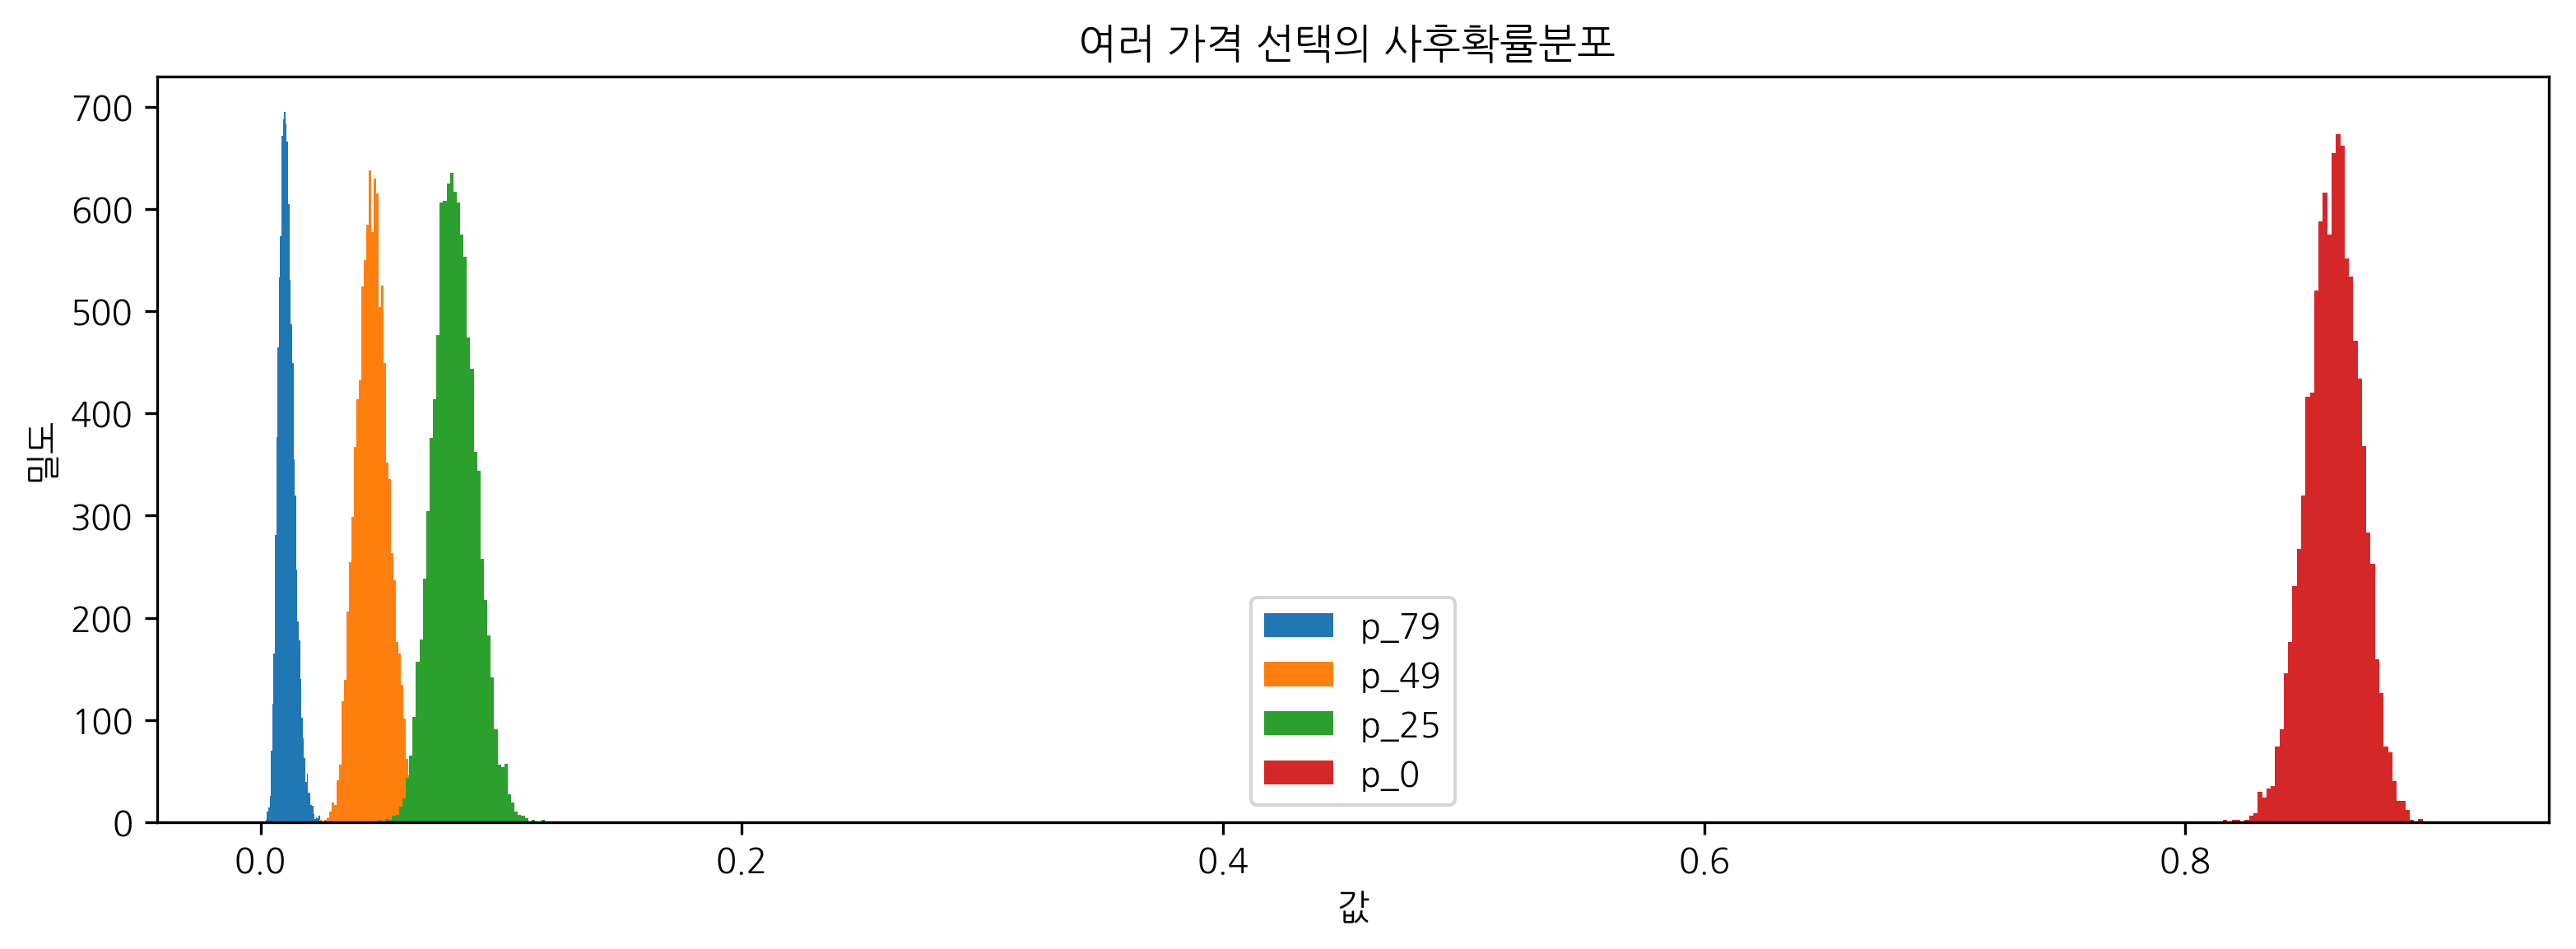

In [23]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50,
        label=label, histtype='stepfilled')
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("여러 가격 선택의 사후확률분포 ")
plt.legend();

위의 그림에서 볼 수 있듯이 우리가 추정하는 확률값에 여전히 불확실성이 존재하므로 기댓값에도 불확실성이 존재할 것이다. 괜찮다. 우리가 얻은것은 우리의 기댓값에 대한 사후확률분포다. 다음과 같은 `expected_revenue()` 함수를 통해 디리클레 사후확률분포에서 얻은 각각의 표본을 매개변수로 넘겨 기댓값에 대한 사후확률분포를 얻는다.

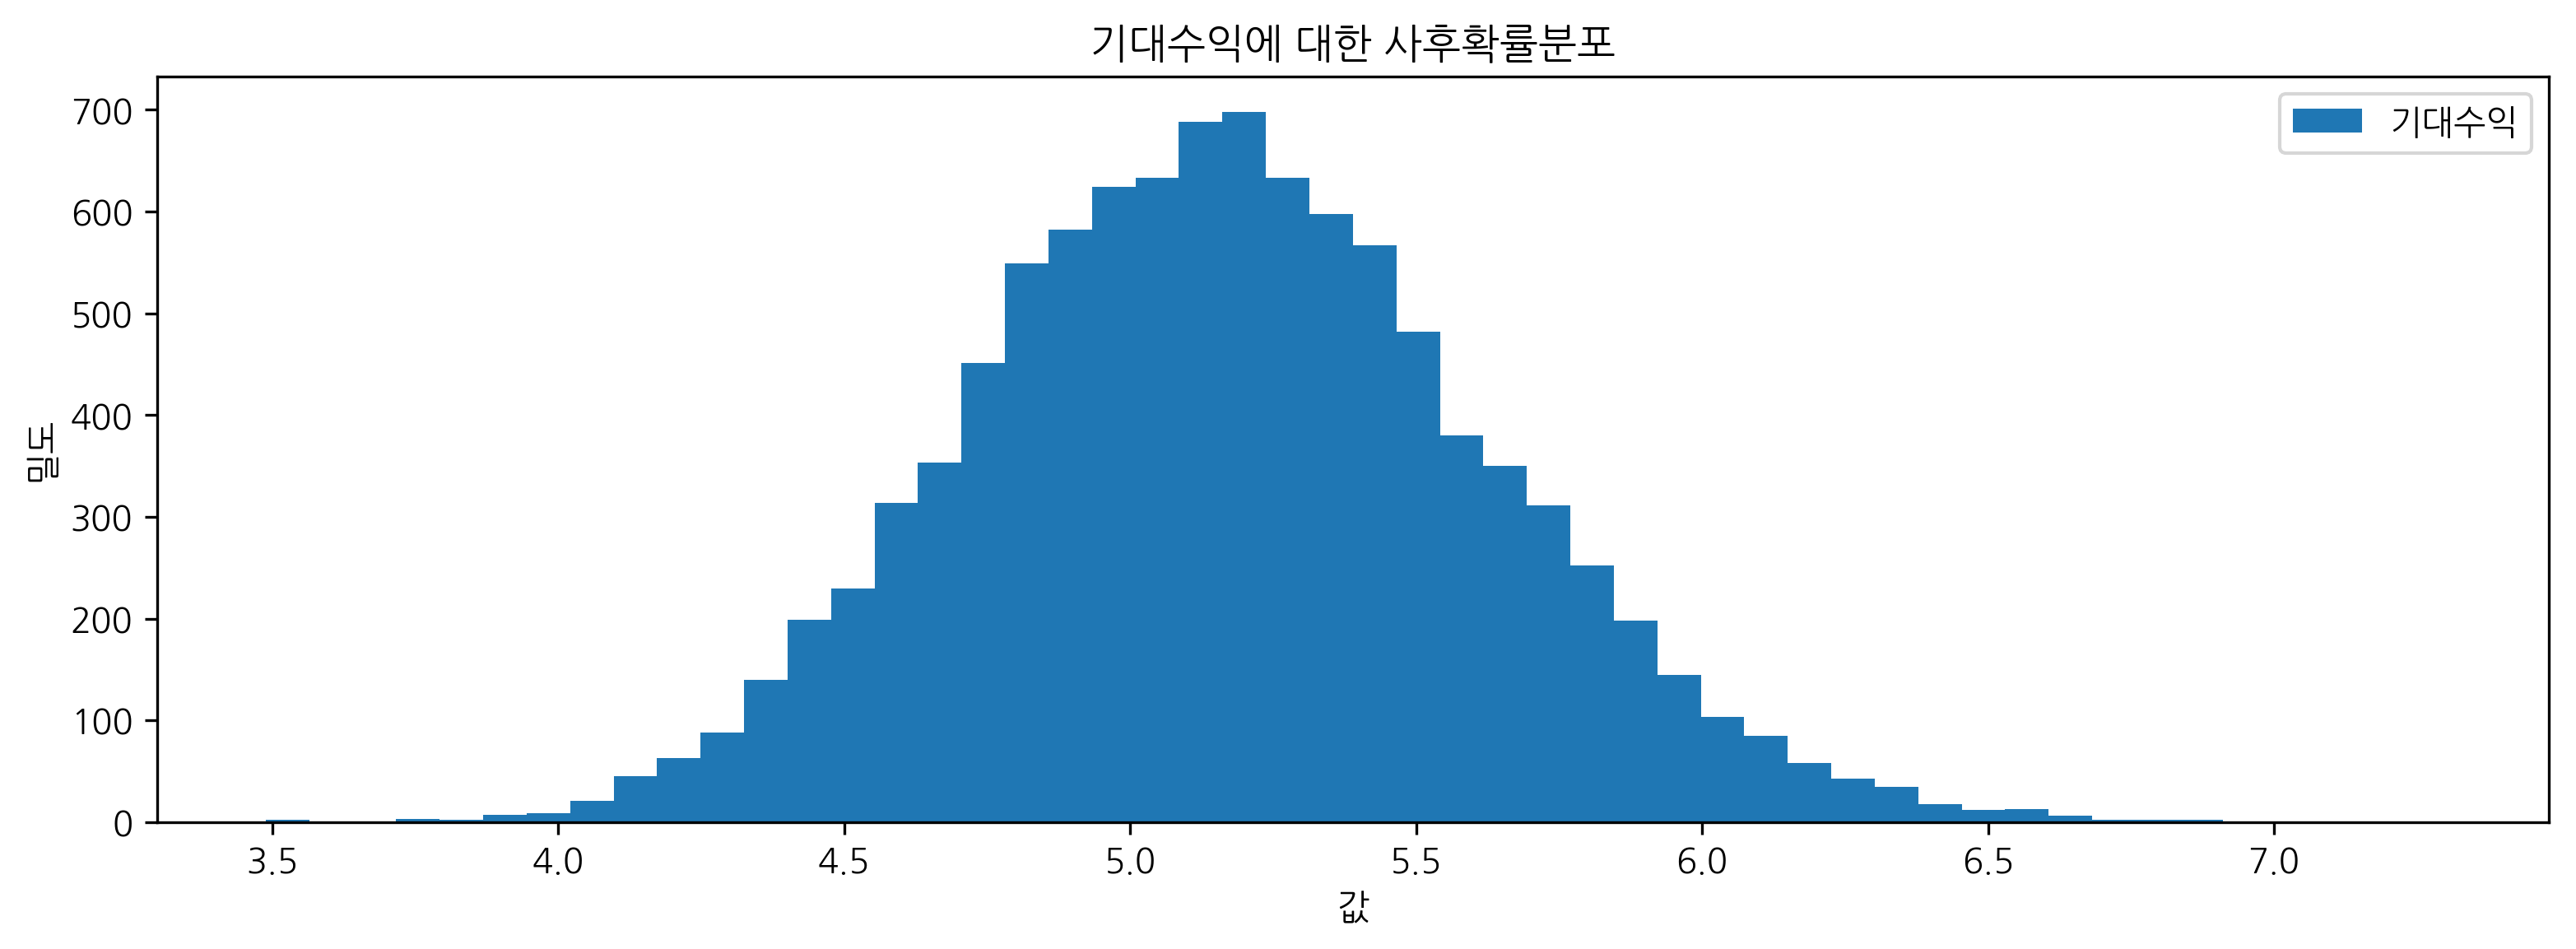

In [27]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:,1] + 25*P[:,2] + 0*P[:,3]

posterior_expected_revenue = expected_revenue(posterior_samples)

plt.hist(posterior_expected_revenue, histtype='stepfilled',label='기대수익', bins=50)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("기대수익에 대한 사후확률분포")
plt.legend();

위의 그림을 통해 기대수익은 \$4~\$6 사이일 가능성이 있고, 이 범위를 벗어날 가능성은 없다는 걸 알 수 있다.

### 7.3.2 A/B 실험 확장하기

A 사이트와 B 사이트라는 두 가지 다른 웹페이지를 가지고 이 분석을 시도해보자. 이를 위해 인위적인 데이터를 만들었다.

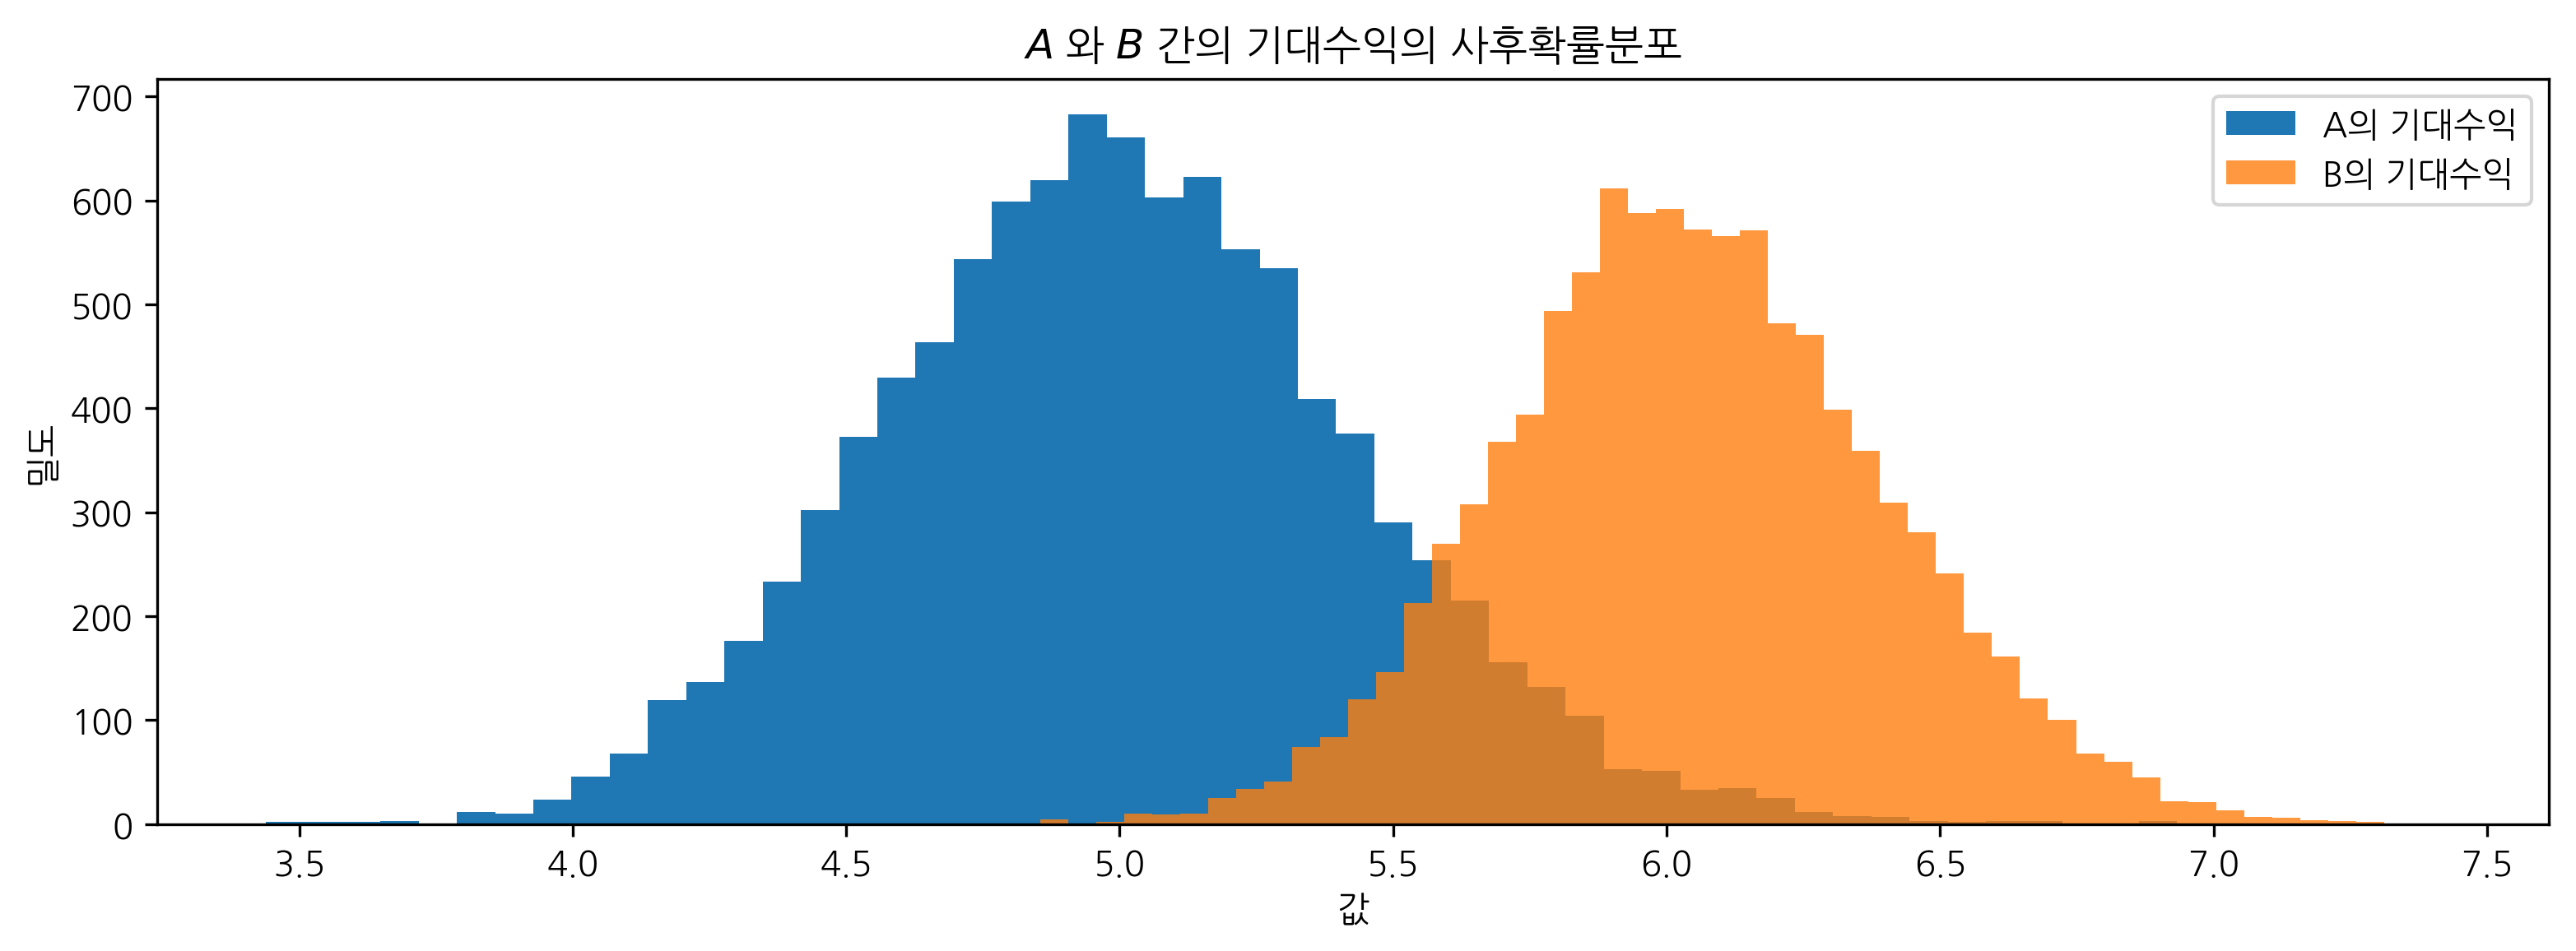

In [28]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_49)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_49)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)


posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled',
    label='A의 기대수익', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled',
    label='B의 기대수익', bins=50, alpha=0.8)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("$A$ 와 $B$ 간의 기대수익의 사후확률분포")
plt.legend();

위의 그림에서 두 사후확률분포가 얼마나 떨어져 있는지 확인할 수 있으며, 이는 웹페이지 성능이 꽤 차이가 난다는 것을 의미한다. 이러한 차이가 존재하는지 확인하기 위해 B 페이지의 수익이 A 페이지보다 클 확률을 살펴보자.

In [29]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print ("B 페이지가 A 페이지보다 수익이 클 확률: %.3f"%p)

B 페이지가 A 페이지보다 수익이 클 확률: 0.970


96%라는 값은 상당히 높은 값이므로 기업은 앞으로 B 페이지를 선택해야 한다. 

살펴봐야 할 또 다른 흥미로운 점은 페이지 간 수익의 사후적인 차이다. 베이지안 분석을 사용하고 있으므로 이것을 분명히 얻을 수 있다. 두 기대수익의 사후분포 간 차이를 히스토그램으로 간단히 볼 수 있다.

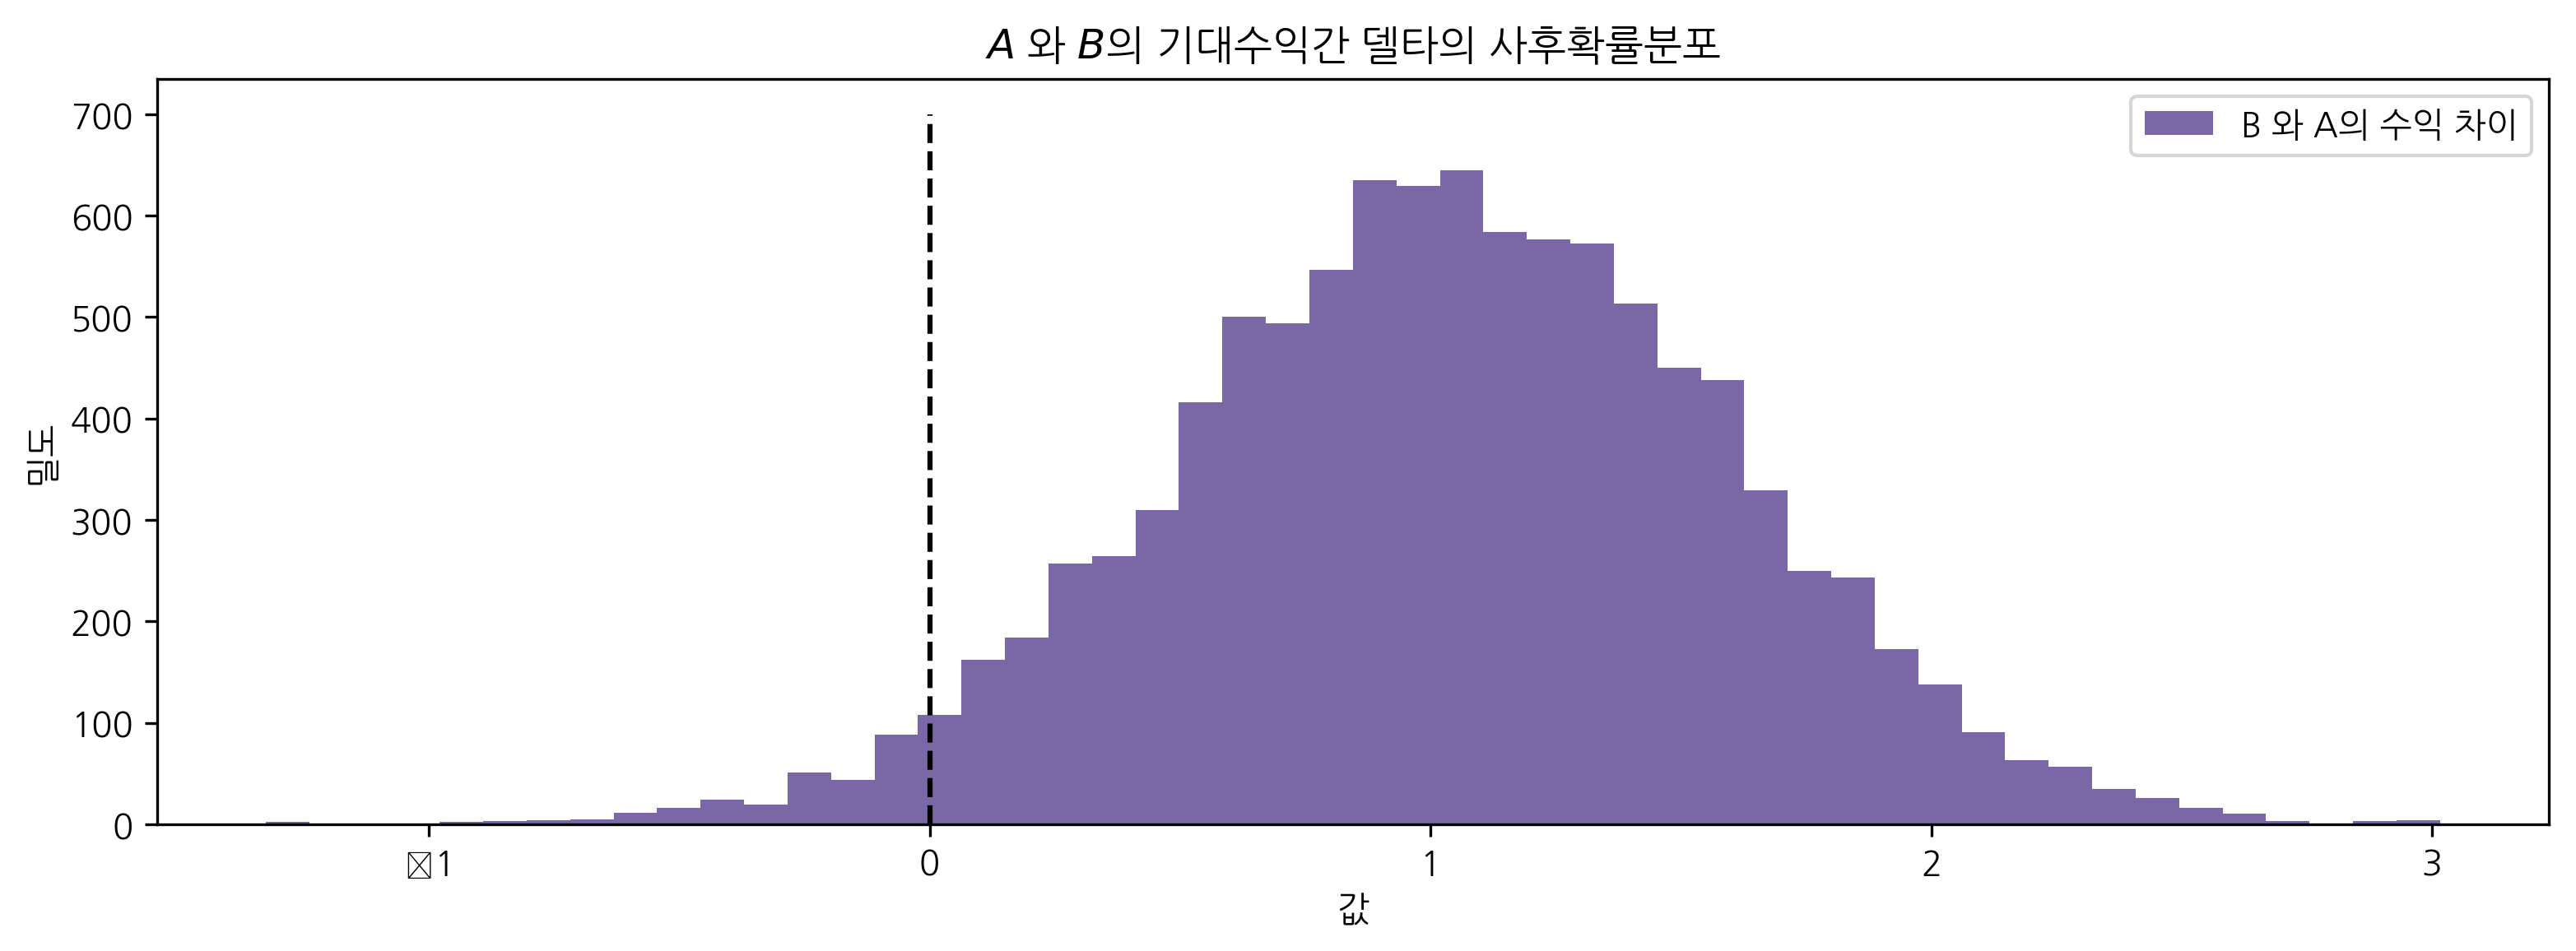

In [30]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',
    label='B 와 A의 수익 차이', bins=50)
plt.vlines(0, 0, 700, linestyles='--')
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("$A$ 와 $B$의 기대수익간 델타의 사후확률분포")
plt.legend();

이 사후확률분포를 보면 그 차이가 \$1 이상일 가능성이 50% 정도고, 심지어 \$2 이상일 수도 있음을 알 수 있다.

## 7.4 전환율을 넘어서: t-검정(t-test)

기존의 t-검정은 빈도주의 통계학의 검정으로 표본평균이 선결 값(predetermined value)에서 벗어나는지를 알아보는 것이다. 존 K. 크루쉬케(John K. Kruschke)에 의해 보급된 베이지안 버전의 t-검정이 있다. ‘Bayesian Estimation Supersedes the t-test’를 줄여 BEST라고 불리는 모델이다.

### 7.4.1 t-검정 설정

다음과 같은 A/B 테스트 주제가 있다. 사용자가 테스트 페이지에 머무는 시간에 대한 데이터를 가지고 있다고 가정하자. 이 데이터는 이산적이 아니라 연속형 데이터다. 예를 들어 다음 코드를 사용하여 인공적인 데이터를 만들것이다.

In [32]:
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 26, 7
# create durations (seconds) users are on the pages for
# 사용자가 페이지에 머무는 시간(초단위)을 만든다
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

print (durations_A[:8])
print (durations_B[:8])

[ 37.45263531  26.21525001  30.35808489  36.3263595   31.39954027
  26.31630761  24.66794114  33.00618883]
[ 24.2078849   28.74556851  24.11091021  21.8820958   31.75820318
  35.9653672   29.69200342  28.80051681]


우리가 할 일은 사용자가 A 또는 B 중 어느 페이지에서 더 오래 머무르는가를알아보는 것이다. 이 모델을 위해 미지수 5개를 가지고 있는데, 평균모수 두개(μ로 표기), 표준편차모수 두 개(σ로 표기), t-검정 특유의 모델모수 ν(‘nu’라고 부른다)다. 모수 ν는 데이터에서 큰 이상치(outlier)들을 볼 수 있는 가능성이 어느 정도인지를 정한다. BEST 모델에 따르면 미지수에 대한 우리의 사전확률분포는 다음과 같다.

- $\mu_A$와 $\mu_B$는 정규확률분포에서 나온다. 사전적인 평균은 A와 B에서 얻은 평
균과 같으며, 사전적인 표준편차는 수집된 표준편차를 1,000배한 값이다(이것은 매우 넓은 균등 사전확률분포다).

In [34]:
import pymc as pm

pooled_mean = np.r_[durations_A, durations_B].mean()
pooled_std = np.r_[durations_A, durations_B].std()
tau = 1./np.sqrt(1000. * pooled_std) # PyMC uses a precision  parameter, 1/sigma**2

mu_A = pm.Normal("mu_A", pooled_mean, tau)
mu_B = pm.Normal("mu_B", pooled_mean, tau)

- $\sigma_A$와 $\sigma_B$는 균등분포에서 나온다. 수집된 표준편차의 1,000의 1에서 1,000배까지로 제한된다(다시 말하지만, 매우 넓은 균등사전확률분포다).

In [35]:
std_A = pm.Uniform("std_A", pooled_std/1000., 1000.*pooled_std)
std_B = pm.Uniform("std_B", pooled_std/1000., 1000.*pooled_std)

- 마지막으로 $\nu$는 이동지수분포에서 추정된다. 이때 모수는 29와 같다. BEST의 흥미로운 점한 가지는 $\nu$가 두 그룹 간에 공유되고 있다는 점이다. 다음 다이어그램을 보면 분명하게 알 수 있다.

![](./images/BEST.PNG)

In [36]:
nu_minus_1 = pm.Exponential("nu-1", 1./29)

obs_A = pm.NoncentralT("obs_A", mu_A, 1.0/std_A**2, nu_minus_1 + 1,
    observed=True, value=durations_A)
obs_B = pm.NoncentralT("obs_B", mu_B, 1.0/std_B**2, nu_minus_1 + 1,
    observed=True, value=durations_B)
mcmc = pm.MCMC([obs_A, obs_B, mu_A, mu_B, std_A, std_B, nu_minus_1])
mcmc.sample(25000,10000)

 [-----------------100%-----------------] 25000 of 25000 complete in 17.6 sec

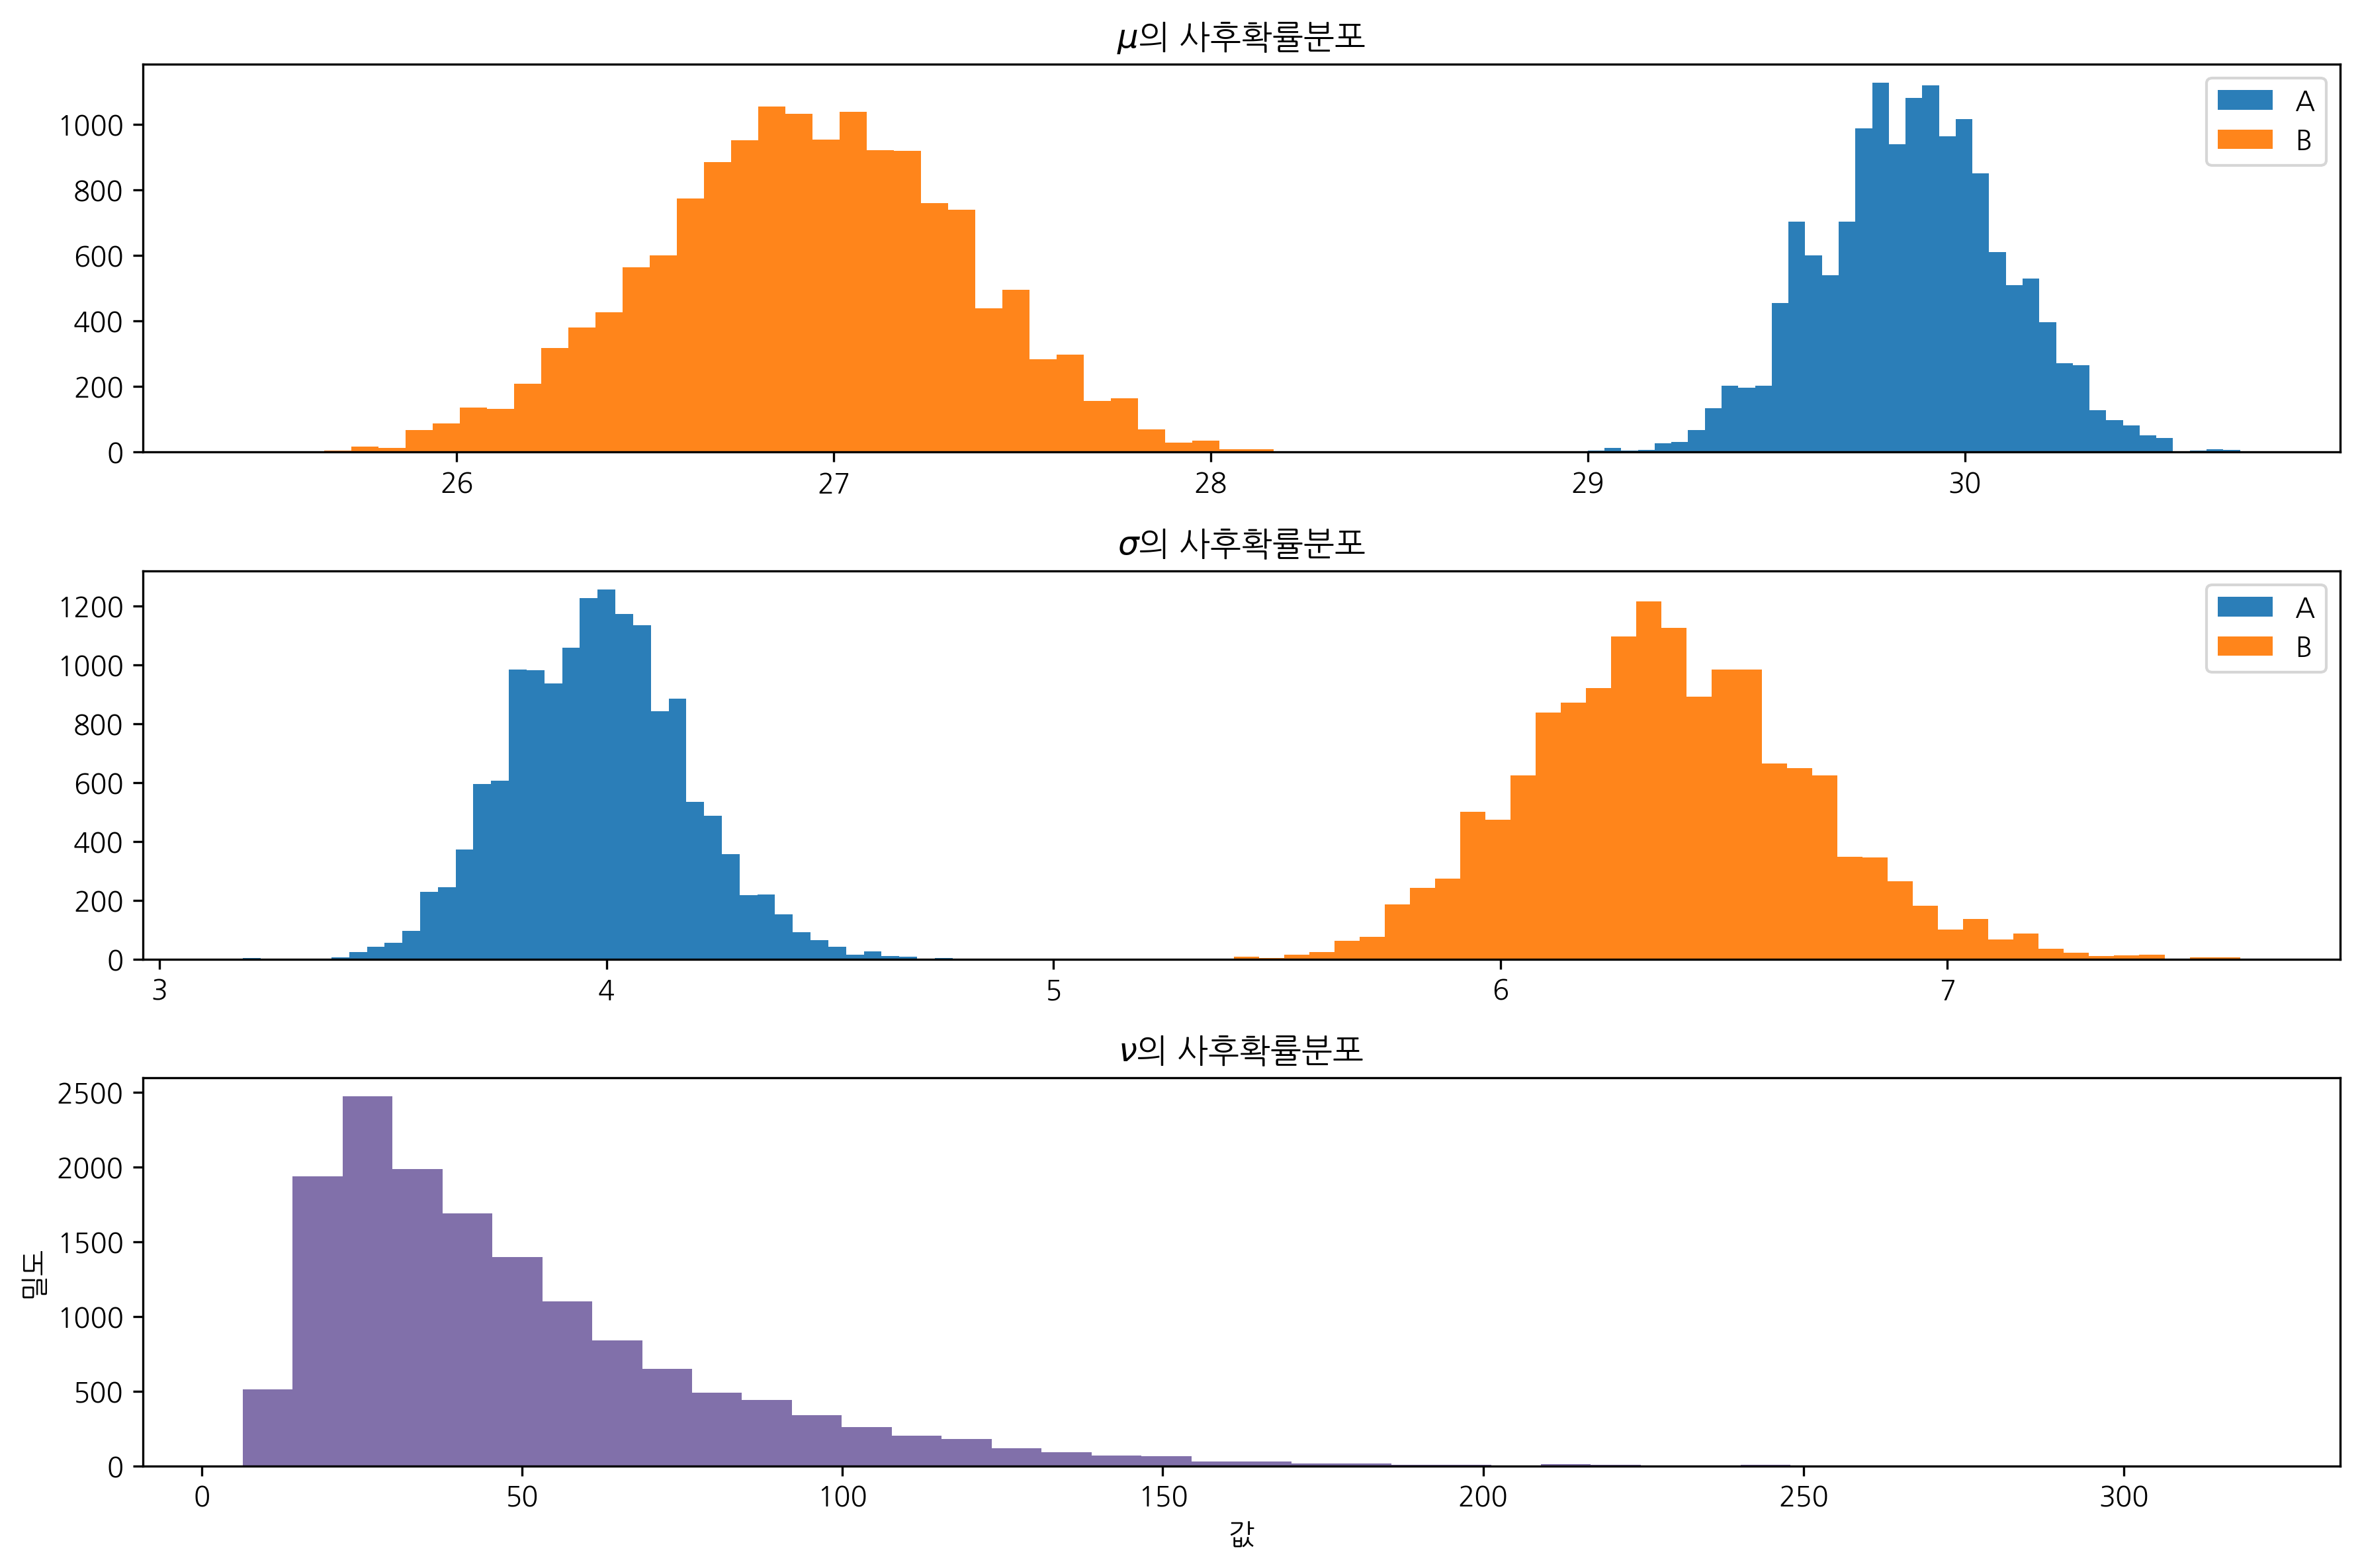

In [37]:
mu_A_trace, mu_B_trace = mcmc.trace('mu_A')[:], mcmc.trace('mu_B')[:]
std_A_trace, std_B_trace = mcmc.trace('std_A')[:], mcmc.trace('std_B')[:]
nu_trace = mcmc.trace("nu-1")[:] + 1

figsize(12,8)

def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled',
        alpha=.95, label=label, **kwargs)

ax = plt.subplot(3,1,1)
_hist(mu_A_trace,'A')
_hist(mu_B_trace,'B')
plt.legend()
plt.title('$\mu$의 사후확률분포')

ax = plt.subplot(3,1,2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.legend()
plt.title('$\sigma$의 사후확률분포')

ax = plt.subplot(3,1,3)
_hist(nu_trace,'', color='#7A68A6')
plt.title(r'$\nu$의 사후확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.tight_layout();

위의 그림에서 두 그룹 간에 분명한 차이가 있음을 알 수 있다(물론 구성상). 첫 번째 그림에 미지수 $\mu_1$과 $\mu_2$의 사후확률분포를 나타내었다.두 번째 그림은 $\sigma_1$과 $\sigma_2$의 분포다. 우리는 A 페이지가 더 높은 평균잔류시간을 가지고 있으며, 각 페이지의 변동성이 낮음(A 페이지의 표준편차가 낮다)을 알 수 있다. 더욱이 이러한 사후확률분포를 가지고 우리는 그룹 간의 차이, 효과 크기(effect size) 등을 계산할 수 있다.

BEST 모델의 한 가지 좋은 성질은 거의 수정 없이 괜찮은 함수로 포장될 수 있다는 점이다.

## 7.5 증분 추정하기

A/B 테스트 이후 의사결정자는 종종 증분의 크기에 관심을 둔다. 그러나 이것은 잘못된 것이다. 이것은 연속형 문제와 이진형 문제를 혼동하는 것으로 볼 수 있다. 

- 연속형 문제는 어느 것이 얼마나 더 나은지를 (가능한 값의 연속적인범위) 측정하려는 시도고, 
- 이진 문제는 무엇이 더 나은지를 (두 개의 가능한 값 중에서) 알아내려는 시도다. 

문제는 연속형 문제에 답하려면 이진형 문제에 답하는 것보다 더 많은 규모의 데이터가 필요하다는 것이다. 그러나 기업은 이진형 문제의 해답을 사용하여 연속형 문제에 답하기를 원한다. 사실 가장 일반적인 통계검정은 앞 절에서 해온 이진형 문제의 해답을 구하려는 시도만 한다.

그럼에도 불구하고 기업은 여전히 두 가지 문제에 대한 해답을 모두 원한다. 우선 무엇을 하지 말아야 할지를 먼저 살펴보자. 여러분이 지금까지 논의한 방법을 사용하여 두 그룹의 전환율을 추정한다고 가정해보자. 기업은 결과에서 상대적인 증가(종종 실험의 향상(lift of experiment)이라고 불린다)를 알고 싶어한다. 일단 떠오른 생각은 순진하게 두 사후확률분포의 평균을 취하고 상대적인 증가를 계산하는 것이다.

$$
\frac{\hat{p}_A - \hat{p}_B}{\hat{p}_B}
$$

이 방법은 몇 가지 심각한 문제를 일으킨다.

우선 $p_A$와 $p_B$의 진짜 값에 대한 모든 불확실성을 묻어버린다. 이전 수식을 사용하여 리프트를 측정함으로써
우리가 이 값들을 정확히 알고 있다고 가정한다. 이것은 거의 항상 값을 과다하게 추정하며, 특히 $p_A$와 $p_B$가 0에 가까울 때 그렇다.

문제는 우리가 불확실성을 보존하고 싶어한다는 것이다. 통계학은 결국 불확실성을 모델링하는 것이다. 이렇게 하기 위해 함수를 통해 사후확률분포를 넘기고, 새로운 사후확률분포를 내놓는 것이다. 이 문제를 가지고 A/B 테스트를 해보자.

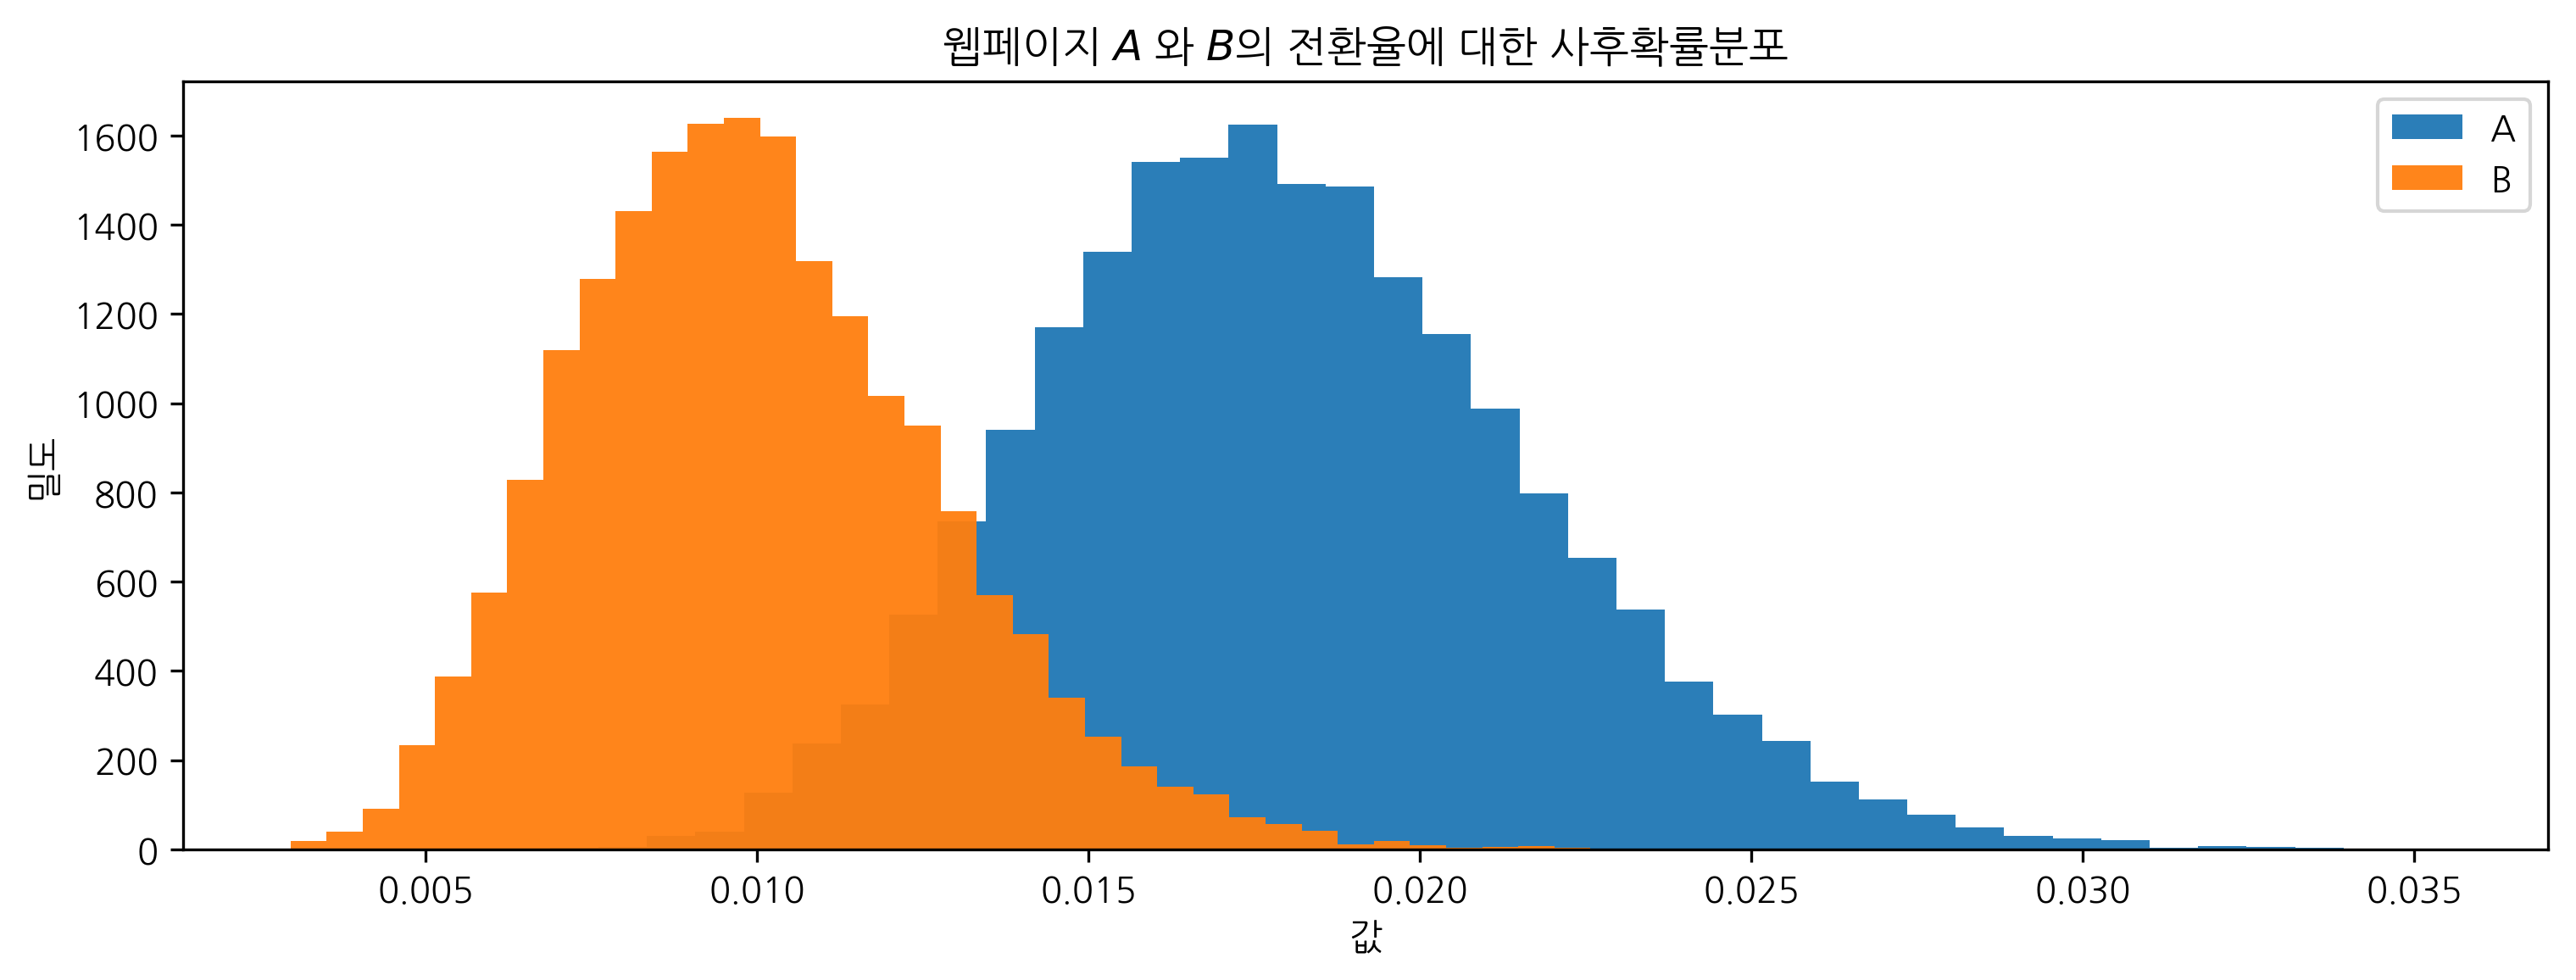

In [38]:

figsize(12,4)
visitors_to_A = 1275
visitors_to_B = 1300
conversions_from_A = 22
conversions_from_B = 12
alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A,
    beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
    beta_prior + visitors_to_B - conversions_from_B)

samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

_hist(samples_posterior_A, 'A')
_hist(samples_posterior_B, 'B')

plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 $A$ 와 $B$의 전환율에 대한 사후확률분포")
plt.legend();

쌍으로 상대적인 증가를 계산하는 함수를 통하여 사후확률분포를 전달할 것이다. 아래 그림에서는 최종 사후확률분포를 볼 수 있다.

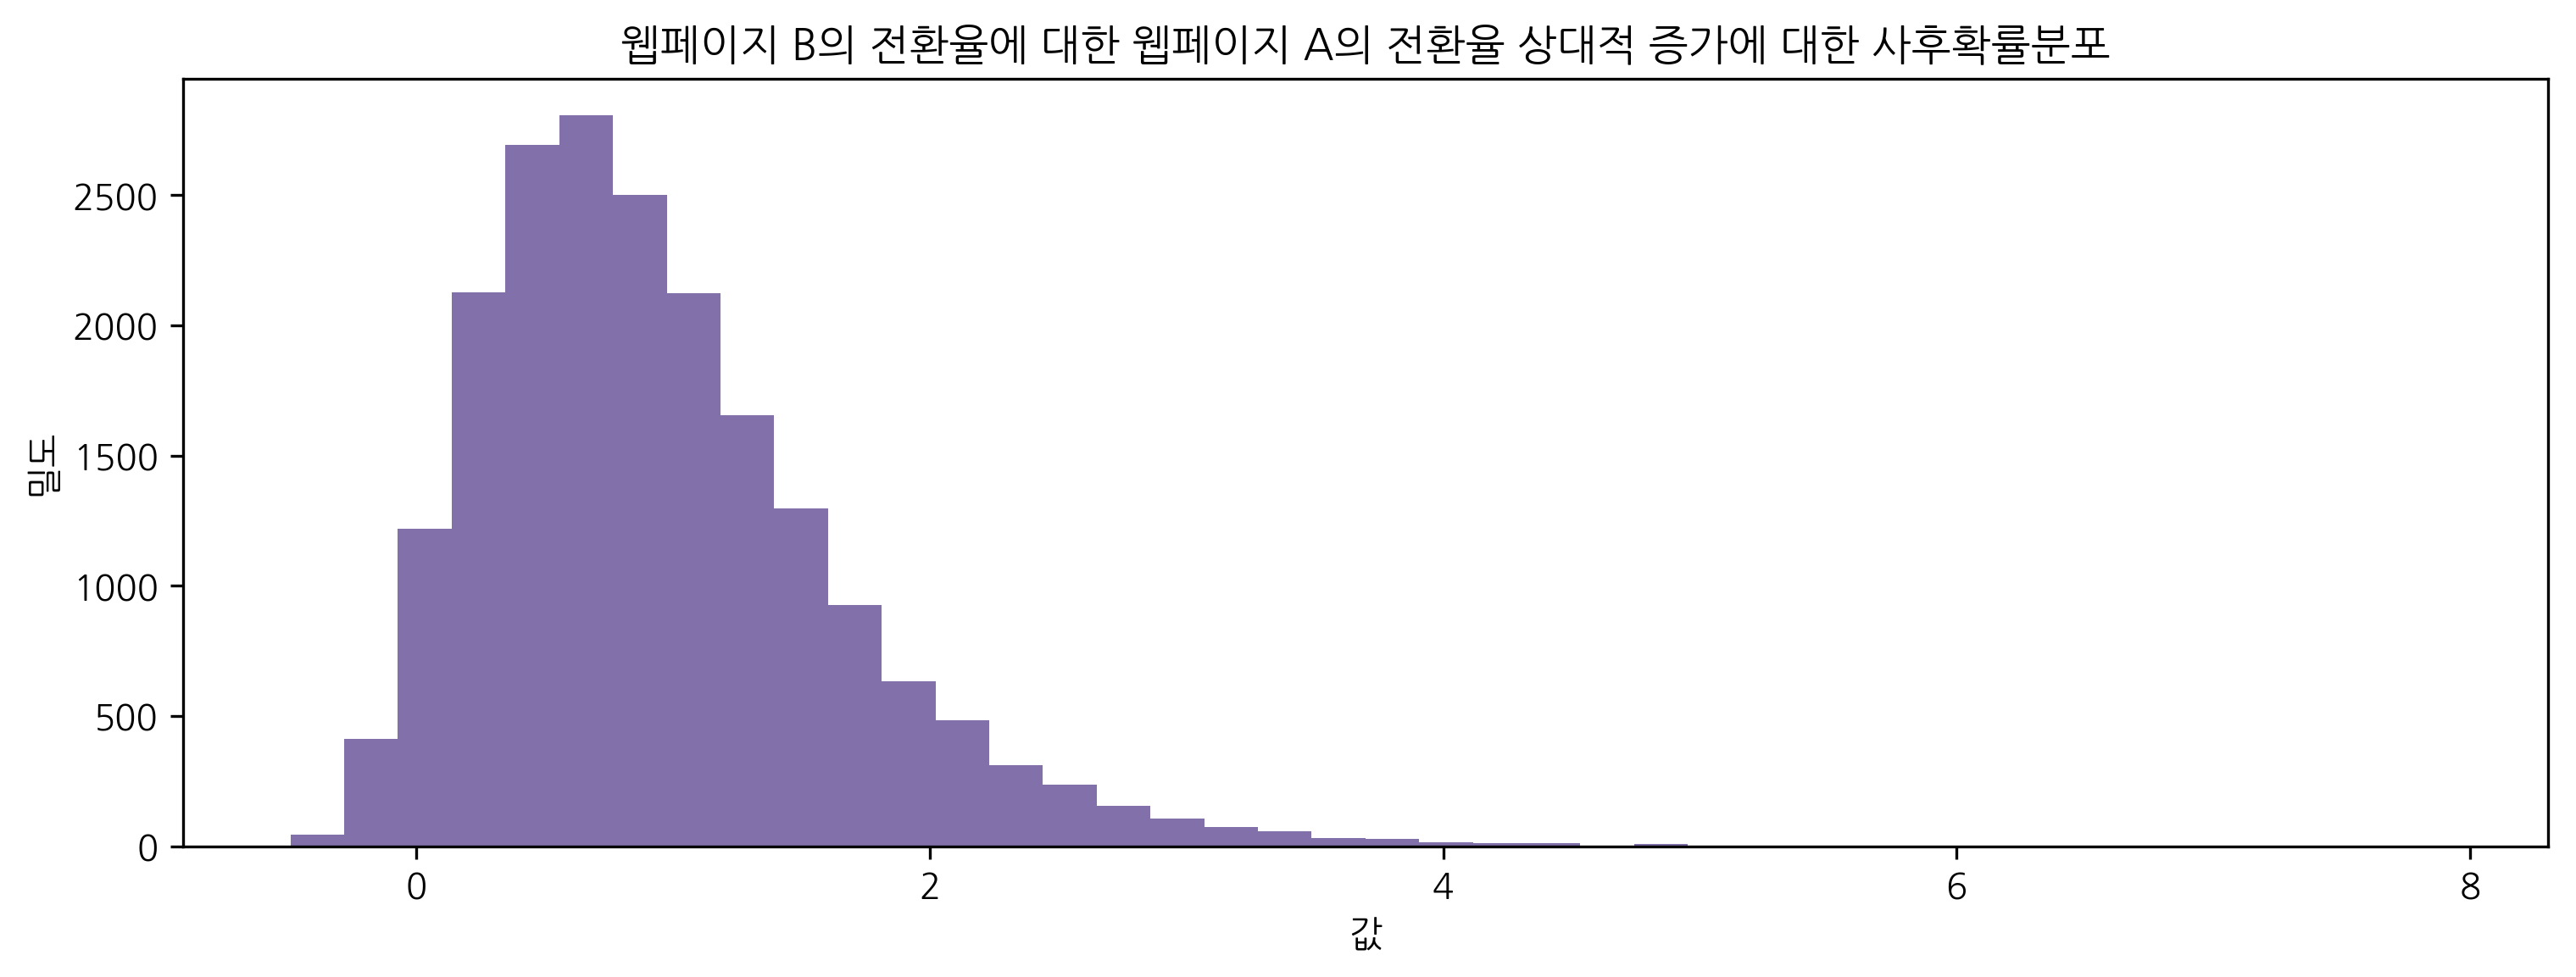

In [39]:
def relative_increase(a,b):
    return (a-b)/b
posterior_rel_increase = relative_increase(samples_posterior_A,
    samples_posterior_B)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("웹페이지 B의 전환율에 대한 웹페이지 A의 전환율 상대적 증가에 대한 사후확률분포")
_hist(posterior_rel_increase, 'relative increase', color='#7A68A6');

다음 계산을 통해 상대적인 증가가 20% 정도 일어날 확률이 89%임을 알 수 있다. 기대증가율이 50%로 늘어날 확률은 72%다.

In [40]:
print ((posterior_rel_increase > 0.2).mean())
print ((posterior_rel_increase > 0.5).mean())

0.8886
0.7142


만일 우리가 다음과 같이 순수한 점추정을 한다면,

$$
\hat{p}_A = \frac{22}{1275} = 0.017
$$

$$
\hat{p}_B = \frac{12}{1300} = 0.009
$$

상대적 증가에 대한 우리의 추정치는 87%다. 아마도 상당히 높은 값일 것이다.

### 7.5.1 점추정량 만들기

이전에 말했듯이 누군가에게 어떤 분포를 그냥 넘겨주는 것은 바람직하지 못하다. 특히 달랑 숫자 하나를 바라는 사람이라면 더 그렇다. 그럼 어떻게 해야할까?

1. **상대적인 증가에 대한 사후확률분포의 평균을 돌려준다.** 사실 이책의 저자는 이 방법을 좋아하지 않는다. 이유를 설명하면 다음과 같다. 위의 그림을 보면 우리는 가능한 값들에서 오른쪽 긴 꼬리를 볼 수 있다. 이것은 편중분포(skewed distribution)를 의미한다. 우리가 편중분포를 가지고 있는 경우 평균과 같은 요약통계는 꼬리에 의해 과다한 영향을 받는다. 그래서 우리는 꼬리를 과도하게 표현하고 실제 상대증가를 과다추정할 수 있다.
2. **상대적인 증가에 대한 사후확률분포의 중앙값을 돌려준다.** 앞에서 논의했던 것을 돌아볼 때 중앙값은 더 적절한 선택이다. 중앙값은 편중분포에 대해 더욱 안정적이다. 하지만 실제로 나는 중앙값이 전체적으로 부풀려진 값을 주는 것을 봤다.
3. 상대적 증가 사후확률분포의 퍼센타일(50% 이하)을 돌려준다. 예를 들어 분포의 30번째 퍼센타일을 돌려주는 것이다. 이것은 바람직한 두 가지 속성을 가진다. 
    - 첫 번째, 이 방법은 수학적으로 상대증가 사후확률분포 위에 손실함수를 적용하는 것과 동등하며 이 사후확률분포는 과소추정보다는 과대추정을 벌점화하는 것이다. 그래서 이 값은 보수적인 추정이다. 
    - 두 번째는 우리가 실험에서 더 많은 데이터를 얻을수록 상대적인 증가에 대한 사후확률분포는 더욱 날씬한 모습이 되는데, 이는 어떤 퍼센타일도 결국같은 점으로 수렴함을 의미한다.

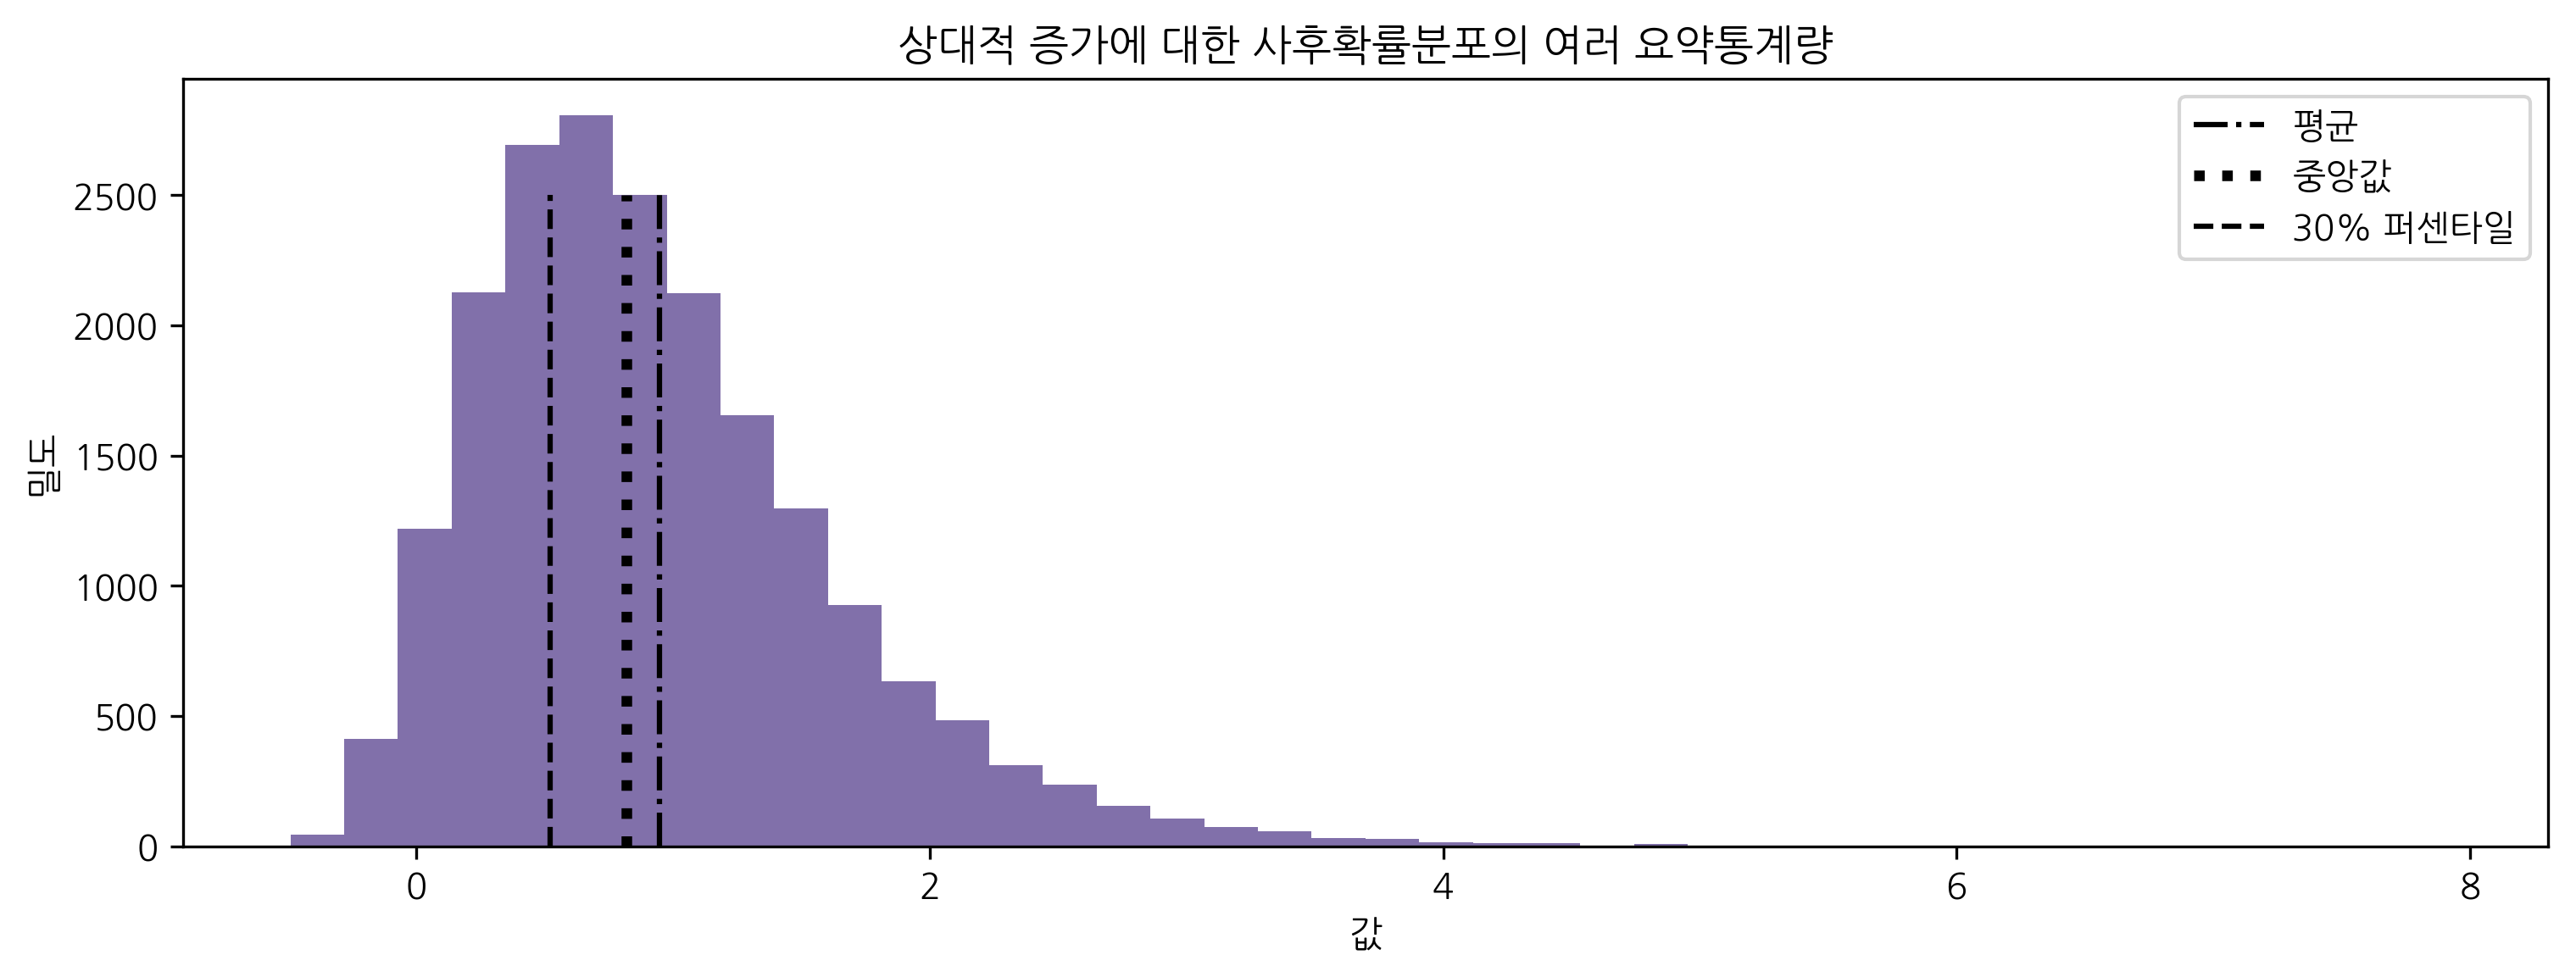

In [41]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)
_hist(posterior_rel_increase,'', color='#7A68A6');
plt.vlines(mean, 0, 2500, linestyles='-.', label='평균')
plt.vlines(median, 0, 2500, linestyles=':', label='중앙값', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
    label='30% 퍼센타일')
plt.xlabel('값')
plt.ylabel('밀도')
plt.title("상대적 증가에 대한 사후확률분포의 여러 요약통계량")
plt.legend();

## 7.6 결론

이 장에서는 베이지안 A/B 테스트가 무엇인지 다루었다. 기존 방법과 비교하여 베이지안 A/B 테스트의 매우 큰 장점 두 가지는 다음과 같다.

1. **해석 가능한 확률**: 베이지안 분석에서 여러분은 “우리가 틀릴 확률이 얼마인가?”라는 질문에 바로 답할 수 있다. 빈도주의 통계에서는 대답하기 어렵거나 불가능하다.
2. **손쉬운 손실함수 적용**: 우리는 5장에서 손실함수가 어떻게 추상적인 확률분포와 실제 세계를 연결하는지 살펴보았다. 이 장에서는 선형손실함수를 적용하여 페이지 뷰당 기대수익을 알아내고, 또 다른 손실함수를 사용하여 적절한 점추정을 하였다. 다른 분야에 응용한 경우와 마찬가지로 베이지안 분석은 다른 방법에 비해 더욱 유연하고 해석 가능하며, 더 복잡한 모델의 경우 적당한 계산 비용만 든다. 나는 베이지안 A/B 테스트가 기존 방법보다 더 보급되어 곧 보편적이 될 거라고 예상한다.